In [ ]:
hasattr

In [1]:
import pandas as pd
from pathlib import Path
import pathlib
import os
import numpy as np
import torch
from torch.utils.data import Dataset

from shapely.geometry import Polygon
import pdb
import  cv2
import PIL

In [2]:
OPENSLIDE_PATH=Path('openslide-win64-20230414')

OPENSLIDE_FOLDER=os.path.join(Path().resolve(),'openslide-win64-20230414','openslide-win64-20230414','bin')

In [3]:
if hasattr(os,'add_dll_directory'):
    with os.add_dll_directory(OPENSLIDE_FOLDER):
        import openslide
else:
    import openslide
    
    

In [ ]:
def append_openslide_to_PATH(openslide_folder:str):
    """append openslide bin installation to PYTHONPATH from a fresh install of openslide 
       at the 'openslide_folder'. The path of the oprnslide folder is relative to the current file """
    
    if not hasattr(PIL.Image, 'Resampling'):  # Pillow<9.0
        PIL.Image.Resampling = PIL.Image
    
    
    curr_abs_path=pathlib.Path().resolve()
    openslide_abs_path=curr_abs_path/openslide_folder/openslide_folder/'bin'
    #sys.path=[str(openslide_abs_path)]+sys.path
    os.environ['PATH'] = str(openslide_abs_path) + ';' + os.environ['PATH']
    

In [2]:
def append_openslide_to_PATH(openslide_folder:str):
    """append openslide bin installation to PYTHONPATH from a fresh install of openslide 
       at the 'openslide_folder'. The path of the oprnslide folder is relative to the current file """
    
    if not hasattr(PIL.Image, 'Resampling'):  # Pillow<9.0
        PIL.Image.Resampling = PIL.Image
    
    
    curr_abs_path=pathlib.Path().resolve()
    openslide_abs_path=curr_abs_path/openslide_folder/openslide_folder/'bin'
    #sys.path=[str(openslide_abs_path)]+sys.path
    os.environ['PATH'] = str(openslide_abs_path) + ';' + os.environ['PATH']
    


OPENSLIDE_PATH='openslide-win64-20230414'
try:
    import openslide
    from openslide import OpenSlide
except OSError:
    append_openslide_to_PATH(OPENSLIDE_PATH) 
    import openslide
    from openslide import OpenSlide
    

In [10]:


from shapely.geometry import Polygon
import pandas as pd
from pathlib import Path
import pathlib
import os
import numpy as np
from typing import Tuple
import json
import openslide
import pdb








    
class AnnotationParser():
    """ Parses WSI Files and associated GeoJson annotations to create a composite data frame
         from both.Also returns the annotations as line items for which th eparsing didn't work 
         Requires folder containing WSI files and Annotations"""
    
    def __init__(self,image_path:pathlib.Path,labels_path:pathlib.Path)->None:
        self.image_path=image_path
        self.labels_path=labels_path
        
        
        
    
    
    
    def get_img_df(self)->pd.DataFrame:
        """use openslide to get properties,shape,levels etc.for each image"""
        img_paths=[self.image_path/fn for fn in os.listdir(self.image_path)  if (self.image_path/fn).suffix == '.tiff']
        img_df=pd.DataFrame({'image_path':img_paths})
        img_df=img_df.assign(image_name=[img_path.stem for img_path in img_paths],
                             WSI_size=[openslide.OpenSlide(img_path).dimensions for img_path in img_paths],
                      levels=[openslide.OpenSlide(img_path).level_count for img_path in img_paths],
                    downsample_levels=[{level:downsample for level,downsample in enumerate(openslide.OpenSlide(img_path).level_downsamples)} 
                           for img_path in img_paths])
        return img_df


    
    def get_coordinates_array(self,anno_row:pd.Series)->np.ndarray:
        """parse the annotation json (as a series of rows to get coordinates
           of the annotation as an array of dim n_points X 2 """
        
       
        
        try:
            coord_list=anno_row['geometry']['coordinates']
        except KeyError:
            
            return 'coordinates_key_error'
        
        ### last 2 dimensions of every poly are n_points X 2
       # pdb.set_trace() 
        try:
            poly_arrays=[np.array(poly).reshape((np.array(poly).shape)[-2:]) for poly in coord_list]

        except:
            pdb.set_trace()
            
        
        
       
        ## to get largest polygon if more than one get marked
        largest_poly=max(poly_arrays,key=len)
        #largest_poly=max(coord_list,key=lambda x:len(max(x,key=len))
        
       
        return largest_poly

    
    def get_class_name_and_color(self,anno_row:pd.Series)->Tuple[str,int]:
        """Parse annotation to return class name for each anno and color assigned in QuPath"""
        
     
        
        try:
            classification=anno_row['properties']['classification']
            class_name=classification['name']
            class_color=classification['color']
            return class_name,np.array(class_color)
        
        except KeyError:
            
            
            return 'class_name_error',0
        
            
        
    
    def parse_json_file(self,json_path:pathlib.Path):
        # need to be list of dicts (anno_list)
        with open(json_path) as json_file:
            anno_list = json.load(json_file)
            if not isinstance(anno_list, list):
                anno_list=[anno_list]
            
        
        anno_df=pd.DataFrame(anno_list)
        anno_df=anno_df.assign(image_name=json_path.stem)
        #pdb.set_trace()
        return anno_df

        
    
    def get_anno_df(self,img_df:pd.DataFrame)->Tuple[pd.DataFrame,pd.DataFrame]:
        
        """ get annotation df including annotation for which parsing did not work (errored)"""
        
        jsons=[self.labels_path/fn for fn in os.listdir(self.labels_path)  if (self.labels_path/fn).suffix == '.geojson']
        anno_df=pd.concat([self.parse_json_file(json_path) for json_path in jsons])
        #pdb.set_trace()
        #anno_df=pd.concat([pd.read_json(json,orient='records').assign(image_name=json.stem) for json in jsons],ignore_index=True)
        
        ## enrich with image specific attrs, total size,zoom levels etc.
        anno_df=anno_df.merge(img_df,on='image_name')
        ## add coordinates as np array and shapely polygon with transormed origin 
        anno_df['coordinates']=anno_df.apply(self.get_coordinates_array,1)
        #pdb.set_trace()
        anno_df['class_name'], anno_df['colour_RGB']=zip(*anno_df.apply(self.get_class_name_and_color,1))
        
        ## select the annos with errored coordinates (due to annotation issues)
        errored=np.logical_or(anno_df['coordinates'].isin(['coordinates_key_error']),
                              anno_df['class_name']=='class_name_error')
        
        errored_df=anno_df[errored]
        anno_df=anno_df[~errored]
        
        #pdb.set_trace()
        ## use shapely to compute polygon attrs
        anno_df['polygon']=anno_df.apply(lambda x:Polygon(x['coordinates']),1)
        anno_df['area']=anno_df.apply(lambda x:x['polygon'].area,1)
        anno_df['circumference']=anno_df.apply(lambda x:x['polygon'].length,1)
        #pdb.set_trace()
        
        return anno_df,errored_df
    
    
    
    def parse_annotations(self)->Tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame]:
        """ returns anno_df,img_df and errored df in that order """ 
        img_df=self.get_img_df()
        anno_df,errored_df=self.get_anno_df(img_df)
        
        
        return anno_df,img_df,errored_df
        


In [8]:
from dataloading.src.wsi_datasets import WSI_Multiscale
from dataloading.src.annotation_parser import AnnotationParser


In [ ]:
import pdb
root=Path('WSI_download/WSI_data')

#label_path=root/'labels'
label_path=root/'labels'
image_path=root/'images'

parser=AnnotationParser(image_path,label_path)
anno_df,image_f,errored=parser.parse_annotations()

> c:\users\ananya\appdata\local\temp\ipykernel_17640\2005998499.py(71)get_coordinates_array()



ipdb>  poly_arrays=[np.array(poly).reshape((np.array(poly).shape)[-2:]) for poly in coord_list]


*** ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.


In [174]:
#``10.%%writefile -a dataloading/src/wsi_datasets.py
from torch.utils.data import Dataset
from shapely.geometry import Polygon,MultiPolygon
import  cv2
import numpy as np
import pandas as pd



class WSI_Multiscale(Dataset):
    
   
    
    def __init__(self,
                 anno_df:pd.DataFrame,
                 crop_pixel_size:tuple=(256,256),
                 transform=None)->None:
       
        """Pytorch Dataset class representing a multiscale WSI dataset.inputs are img and anno dfs containing info 
         about WSI images and annotations"""
       
        self.anno_df=anno_df
        ## the size in pixel of  each crop -size is kept same at 
        ## various zoom levels for batching
        self.crop_pixel_size=crop_pixel_size
        self.item_transform = transform
        self.class2num={'Tumor':1}
        

    def __len__(self):
        return len(self.anno_df)
    
    
    def get_random_crop(self,annotation_row:pd.Series)->(torch.tensor,torch.tensor):
        
        """ get a random center crop at any possible zoom level from the periphery
           of an annotation """
       
        downsample_dict=annotation_row['downsample_levels']
        wsi_size,anno_coordinates=(torch.tensor(x) for x in [annotation_row['WSI_size'],
                                                             annotation_row['coordinates']])

        downsample_factors=torch.tensor(list(downsample_dict.values()))


        ## create on self.device
        offsets=torch.tensor(self.crop_pixel_size)//2
        
        offsets_arr=torch.tensor([[-1,1],[1,1],[1,-1],[-1,-1]])*offsets

        ## create offsets to be made from each polygon boundary point

        all_offsets=offsets_arr.unsqueeze(2)*downsample_factors.unsqueeze(0).unsqueeze(0)

        all_crops=all_offsets.unsqueeze(0)+anno_coordinates.unsqueeze(1).unsqueeze(3)
        all_crops=all_crops.permute(0,3,1,2)
        all_crops=all_crops.flatten(end_dim=1)
        

        ## all_crops shape: N_points X Zoom factors X 4 (square tile points) X 2 (x,y coords)

        ## check the boundary of the crops fall within the WSI image
        max_bounds=torch.max(all_crops,axis=1).values<wsi_size.unsqueeze(0)
        min_bounds=torch.min(all_crops,axis=1).values>torch.zeros_like(wsi_size.unsqueeze(0))

        ## get all feasible crops/tiles associated with theat particular annotation
        all_crops=all_crops[torch.logical_and(max_bounds.all(axis=1),min_bounds.all(axis=1))]

       
        random_crop_index=np.random.randint(0,all_crops.shape[0])
        
        ## select the random crop from one of the  vertices and zoom level
        crop=all_crops[random_crop_index]
        crop_sz=crop[:,0].max()-crop[:,0].min()
       
        ## record the zoom level of the chosen crop
        zoom_level_idx=torch.argwhere(downsample_factors*self.crop_pixel_size[0]==crop_sz).flatten()
       
       
        ## return the crop as a tensor of shape 4X2 (with corner coordinates of the crop) and 
        ## zoom level indicated by an index (0-8)
        return np.array(crop),zoom_level_idx
    
    
    def get_intersecting_polys(self,crop_poly:Polygon,anno_poly:Polygon,top_left:np.ndarray):
        """return the intersection between a crop square and annotation polygon
         handles the case when the intersection is a multipolygon"""
        
        intersect=crop_poly.intersection(poly)
        
        
        
        
   
    def get_mask_per_class(self,class_annotation_data:pd.DataFrame,crop:np.ndarray,
                          downsample_factor:float)->torch.tensor:
       
        """"function to create masks of each class given the annotation data and crop(image) 
            coordinates=(4X2 shape) also the donsample factor of the crop to scale the polygon coords"""
        annotation_class=class_annotation_data['class_name'].iloc[0]
        annotation_num=self.class2num[annotation_class]
        
        
        ## select the top left point of the crop
        ## its the point with the min X and Y corrdinates (top left of image is origin)
        
        top_left=crop.min(axis=0)
        
        ## create a shapely polygon from crop to find intersections between annotations and crop
        
        crop_poly=Polygon(crop)
        
        ## create list of intersecting polygons with crop to fill with clss encoding
        
        intersects=[]
        for poly in  class_annotation_data['polygon']:
            if not crop_poly.intersects(poly):
                continue
            else:
                intersect=crop_poly.intersection(poly)
                
                if isinstance(intersect,MultiPolygon):
                    for inter in intersect.geoms:
                        ext_coords=((np.array(inter.convex_hull.exterior.coords)-top_left)//downsample_factor).astype(np.int32)
                        intersects.append(ext_coords)
                elif isinstance(intersect,Polygon):
                        ext_coords=((np.array(intersect.convex_hull.exterior.coords)-top_left)//downsample_factor).astype(np.int32)
                        intersects.append(ext_coords)
                else:
                        continue
                        
                        
                

                    
        mask=np.zeros(self.crop_pixel_size,dtype=np.uint8)
        
       
        ## fill the intersected polygons within the mask
        cv2.fillPoly(mask,intersects,color=annotation_num)
        
        return torch.tensor(mask,dtype=torch.uint8)
        
        
        
    def read_slide_region(self,slide_obj:openslide.OpenSlide,top_left:np.array,
                         level:int):
        """ returns the pixel RGB from WSI given a location,crop_size and level"""
        #pdb.set_trace()
        return slide_obj.read_region(tuple(top_left),level,self.crop_pixel_size)

    
    def __getitem__(self, index):
        ## select annotation 
        anno_row=self.anno_df.iloc[index]
        
        ## select all annotations in the same image as indexed annotation
        image_name,anno_class=anno_row['image_name'],anno_row['class_name']
        dowsample_levels=anno_row['downsample_levels']
        image_path=anno_row['image_path']
        image_anno_data=self.anno_df[self.anno_df['image_name']==image_name]
        
        ## select random crop from the annotation
        crop,zoom_level_idx=self.get_random_crop(anno_row)
        
        ## get the top left corner of the crop
        top_left=crop.min(axis=0).astype(np.int32)
         ## Zoom level idx is a tensor convert to int to use as level in openslide
        zoom_level=zoom_level_idx.item()
        
        ## Zoom level is a tensor convert to int to use as key
        downsample_factor=dowsample_levels[zoom_level]
        
        crop_RGB=self.read_slide_region(openslide.OpenSlide(image_path),
                                        top_left,
                                        zoom_level)
                                        
        
       ## get  classwise masks from the selected crop by selecting all annos on the same image
        ## and within the same crop
        
        get_classwise_masks=partial(self.get_mask_per_class,
                                          crop=crop,
                                          downsample_factor=downsample_factor)
        
        
      
        class_wise_masks=image_anno_data.groupby('class_name').apply(get_classwise_masks)
        
       
        
       
        ## stack the masks of various classes
        stacked_masks=torch.stack(class_wise_masks.to_list(),dim=0)
       
        ## create a composite mask with higher class numbers taking precedence in case of ties
       
        composite_mask=stacked_masks.max(dim=0)
        img_tens=torch.tensor(np.array(crop_RGB))[:,:,:-1].permute(2,0,1)
        
        return img_tens,composite_mask.values,zoom_level_idx

Appending to dataloading/src/wsi_datasets.py


In [17]:
#%%writefile -a dataloading/src/wsi_datasets.py


In [5]:
from sklearn.model_selection import train_test_split
ds_train,ds_val=(WSI_Multiscale(df) for df in train_test_split(anno_df,test_size=0.2,random_state=42))

In [23]:
dl_train,dl_val=ds_train.get_dl(batch_size=16),ds_val.get_dl(batch_size=8)

In [13]:
import segmentation_models_pytorch as smp

unet = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

In [26]:
img_b,mask_b,zoom_b=next(iter(dl))

D:\Projects_2023\morphle_wsi_scans\dataloading\src\wsi_datasets.py:117: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  offsets=torch.tensor(self.crop_pixel_size)//2


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

# Define your PyTorch Lightning module (inherits from pl.LightningModule)
class SegLightningModule(pl.LightningModule):
    def __init__(self, segmentation_model):
        super(SegLightningModule, self).__init__()
        # Define your model architecture here
        self.segmentation_model=segmentation_model

    def forward(self, x):
        # Define the forward pass of your model
        
        return self.segmentation_model(x)
    
    def flattened_cross_entropy_loss(self,inp,tgt):
        
        tgt=tgt.flatten(start_dim=-2)
        inp=inp.flatten(start_dim=-2)
      
        return nn.functional.cross_entropy(inp, tgt)
    
    
    def training_step(self, batch, batch_idx):
        # Define the training step
      
        img_b,mask_b,zoom_b=batch
        img_b=img_b.to(torch.float32)
        mask_b=mask_b.to(torch.int64)
        zoom_b=zoom_b.to(torch.int64)
        y_pred = self(img_b)
        loss = self.flattened_cross_entropy_loss(y_pred, mask_b)
        self.log('train_loss', loss)  # Log the training loss for TensorBoard
        return loss

    def configure_optimizers(self):
        # Define your optimizer
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [14]:
seg_model=SegLightningModule(segmentation_model=unet)

In [15]:
trainer = pl.Trainer(max_epochs=10, gpus=1)
trainer.fit(model=seg_model, train_dataloaders=dl_train,val_dataloaders=dl_val)

D:\Anaconda3\envs\fastai2022\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
D:\Anaconda3\envs\fastai2022\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type | Params
--------------------------------------------
0 | segmentation_model | Unet | 24.4 M
------------------

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [16]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 15596), started 0:12:25 ago. (Use '!kill 15596' to kill it.)

In [51]:
def comp_fwd(model,img_b):
    out=model.encoder(img_b)
    
    out=model.decoder(out[-1])
    
    out=model.segmentation_head(out)
    return out

In [50]:
model.encoder

segmentation_models_pytorch.decoders.unet.decoder.UnetDecoder

In [31]:
img_b.shape

torch.Size([16, 3, 256, 256])

In [53]:
??model.decoder

Signature:       model.decoder(*input, **kwargs)
Type:            UnetDecoder
String form:    
UnetDecoder(
  (center): Identity()
  (blocks): ModuleList(
    (0): DecoderBlock(
      (conv1): Conv2dReLU(
        (0): Conv2d(768, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (attention1): Attention(
        (attention): Identity()
      )
      (conv2): Conv2dReLU(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (attention2): Attention(
        (attention): Identity()
      )
    )
    (1): DecoderBlock(
      (conv1): Conv2dReLU(
        (0): Conv2d(384, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2

In [41]:
out1=model(img_b.to(torch.float32))

In [81]:
flatout=out1.flatten(start_dim=-2).to(torch.float32)

In [79]:
flatmask=mask_b.flatten(start_dim=-2).to(torch.int64)

In [52]:
out2=comp_fwd(model,img_b.to(torch.float32))

IndexError: tuple index out of range

In [68]:
import torch.nn.functional as F

In [82]:
F.cross_entropy(flatout,flatmask)

tensor(0.6239, grad_fn=<NllLoss2DBackward0>)

In [36]:
import torchvision.models as models

In [37]:
# Load the pre-trained ResNet-34 model
resnet34 = models.resnet34(pretrained=True)




D:\Anaconda3\envs\fastai2022\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
D:\Anaconda3\envs\fastai2022\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
resnet34(img_b.to(torch.float32))

tensor([[-1.2855,  0.4946, -1.9875,  ..., -0.8196,  0.6212,  0.8760],
        [-1.0120,  2.2275, -1.7334,  ..., -0.7448, -0.0830,  0.7978],
        [-0.5925,  0.2857,  1.9531,  ...,  0.7362,  5.9377, -0.4845],
        ...,
        [ 0.1140, -0.3541,  1.2884,  ..., -4.2964, -1.6145,  5.6334],
        [ 0.0620,  1.0166, -1.6989,  ..., -0.9611, -0.4841,  2.4543],
        [-1.5942, -0.9257, -0.4390,  ...,  0.5701,  0.4988,  0.3483]],
       grad_fn=<AddmmBackward0>)

In [39]:
img_b.dtype

torch.uint8

In [35]:
model.encoder(img_b.to(torch.int32))

RuntimeError: expected scalar type Int but found Float

In [24]:
for param in model.segmentation_head.parameters():
    print(param.shape)

torch.Size([2, 16, 3, 3])
torch.Size([2])


In [93]:
img,mask,zoom=ds[2]

D:\Anaconda3\envs\fastai2022\lib\site-packages\ipykernel_launcher.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


In [39]:
anno_df['polygon'].apply(lambda x:x.__class__).value_counts()

<class 'shapely.geometry.polygon.Polygon'>    565
Name: polygon, dtype: int64

In [39]:
import cProfile

# Define the function or expression you want to profile


# Create a profile object
profile = cProfile.Profile()

# Start profiling
profile.enable()

# Call the function or execute the expression you want to profile
img_b,mask_b,zoom_b=next(iter(dl_train))
# Stop profiling
profile.disable()

# Print the profiling results
profile.print_stats(sort=2)


         151770 function calls (148542 primitive calls) in 1.318 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    1.318    0.659 interactiveshell.py:3416(run_code)
        2    0.000    0.000    1.318    0.659 {built-in method builtins.exec}
        1    0.000    0.000    1.318    1.318 1944386479.py:13(<module>)
     23/5    0.000    0.000    1.317    0.263 {built-in method builtins.next}
        1    0.000    0.000    1.317    1.317 dataloader.py:676(__next__)
        1    0.000    0.000    1.317    1.317 dataloader.py:719(_next_data)
        1    0.000    0.000    1.317    1.317 fetch.py:47(fetch)
        1    0.001    0.001    1.315    1.315 fetch.py:49(<listcomp>)
       16    0.001    0.000    1.315    0.082 wsi_datasets.py:223(__getitem__)
       16    0.000    0.000    0.703    0.044 wsi_datasets.py:216(read_slide_region)
       16    0.000    0.000    0.703    0.044 __init__.py:226(r

D:\Anaconda3\envs\fastai2022\lib\site-packages\ipykernel_launcher.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


In [40]:
img_b.shape

torch.Size([16, 3, 256, 256])

In [43]:
mask_b.dtype

torch.uint8

In [20]:
from torchvision.utils import make_grid

In [33]:
import matplotlib.pyplot as plt
grd=make_grid(mask_b.unsqueeze(1),nrow=4)*torch.tensor((0,255,128)).unsqueeze(1).unsqueeze(2)

In [35]:
grd.shape

torch.Size([3, 1034, 1034])

In [57]:
fig = plt.figure(figsize=(16, 12))
grid_img=make_grid(img_b,nrow=4).permute((1,2,0))+grd.permute((1,2,0))
#plt.imshow(grid_img)
plt.imsave('training_batch.jpg',np.array(grid_img.permute(1,0,2).to(torch.uint8)))

<Figure size 1152x864 with 0 Axes>

In [55]:
grid_img.permute(1,0,2).to(torch.uint8)

torch.int64

In [49]:
grid_img.permute(1,0,2).shape

torch.Size([1034, 1034, 3])

In [46]:
grid_img.permute(2,0,1)

torch.Size([1034, 1034, 3])

In [170]:
grd=make_grid(mask_b.unsqueeze(1),nrow=4)*torch.tensor((0,255,128)).unsqueeze(1).unsqueeze(2)

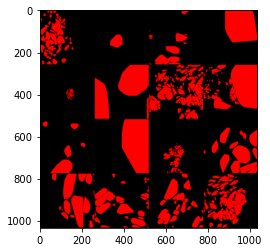

In [152]:
plt.imshow(grd.permute((1,2,0)))

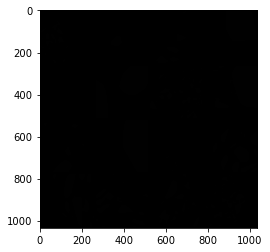

In [146]:
plt.imshow(make_grid(mask_b.unsqueeze(1),nrow=4)*().permute((1,2,0)))

In [32]:
plt

NameError: name 'plt' is not defined

In [51]:
img_b,mask_b,zoom_b=next(iter(dl))

D:\Anaconda3\envs\fastai2022\lib\site-packages\ipykernel_launcher.py:38: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


> c:\users\ananya\appdata\local\temp\ipykernel_15276\2884693963.py(99)get_mask_per_class()



ipdb>  q


BdbQuit: 

In [24]:
t=torch.tensor(np.array(img))[:,:,:-1].permute(2,0,1)

In [17]:
img_b.shape

torch.Size([2, 3, 256, 256])

In [18]:
zoom_b

tensor([[5],
        [3]])

In [26]:
t.permute(2,0,1).shape

torch.Size([3, 256, 256])

In [12]:
img,mask,zoom_level=ds[4]

D:\Projects_2023\morphle_wsi_scans\dataloading\src\wsi_datasets.py:116: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  offsets=torch.tensor(self.crop_pixel_size)//2


In [18]:
np.array(img)[:,:,:-1].shape

(256, 256, 3)

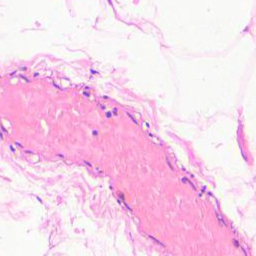

In [73]:
img

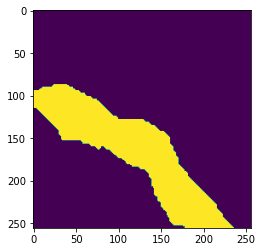

In [74]:
plt.imshow(mask)

In [30]:
import matplotlib.pyplot as plt

In [32]:
mask

torch.return_types.max(
values=tensor([[2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8),
indices=tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]))

In [15]:
tuple(np.array([1,2]))

(1, 2)

In [287]:
d_factor

1.0

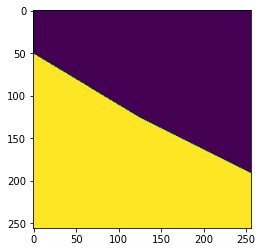

In [286]:
plt.imshow(mask.values)

In [252]:
intersects

[array([[203,  32],
        [200,  33],
        [196,  33],
        [192,  34],
        [187,  35],
        [182,  37],
        [177,  39],
        [168,  44],
        [165,  46],
        [162,  49],
        [159,  52],
        [157,  54],
        [152,  67],
        [153,  82],
        [154,  84],
        [155,  84],
        [157,  84],
        [157,  84],
        [159,  84],
        [160,  83],
        [161,  83],
        [161,  83],
        [162,  83],
        [162,  82],
        [162,  82],
        [163,  82],
        [164,  82],
        [165,  82],
        [173,  82],
        [174,  82],
        [177,  82],
        [177,  82],
        [179,  82],
        [180,  83],
        [180,  83],
        [182,  83],
        [183,  84],
        [184,  84],
        [185,  84],
        [186,  85],
        [186,  85],
        [186,  86],
        [187,  86],
        [187,  86],
        [187,  86],
        [187,  87],
        [187,  87],
        [187,  88],
        [187,  88],
        [187,  89],


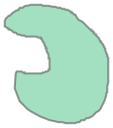

In [253]:
Polygon(intersects[0])

In [206]:
out.values

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]], dtype=torch.uint8)

In [207]:
import matplotlib.pyplot as plt

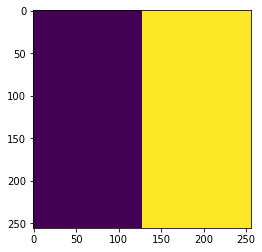

In [208]:
plt.imshow(out.values)

In [126]:
np.random.randint(0,10)

4

In [ ]:
Polygon(np.array()

In [190]:
np.array(5)//np.array(2)

2

In [71]:
anno_df['downsample_levels'].iloc[0]

{0: 1.0, 1: 2.0, 2: 4.0, 3: 8.0, 4: 16.0, 5: 32.0, 6: 64.0, 7: 128.0, 8: 256.0}

In [58]:
p=Polygon([[1,2],[2,2],[1,10]])
np.array(p.exterior.coords,dtype=np.int32)

array([[ 1,  2],
       [ 2,  2],
       [ 1, 10],
       [ 1,  2]])

In [62]:
t=torch.tensor([[1,2],[3,4],[100,2]])

t

tensor([[  1,   2],
        [  3,   4],
        [100,   2]])

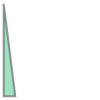

In [59]:
p

In [66]:
cv2.fillPoly(np.zeros((100,100)),np.array(t),color=20)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\drawing.cpp:2396: error: (-215:Assertion failed) p.checkVector(2, CV_32S) >= 0 in function 'cv::fillPoly'


(3, 2)

In [53]:
Polygon

shapely.geometry.polygon.Polygon

In [ ]:
torch.ten

In [35]:
anno_df.columns


Index(['type', 'geometry', 'properties', 'image_name', 'image_path',
       'WSI_size', 'levels', 'downsample_levels', 'coordinates', 'polygon',
       'area', 'circumference', 'class_name', 'colour_RGB'],
      dtype='object')

In [25]:
results_df = pd.DataFrame(results)
results_df

,0
Group,
A,"(9, 3.0)"
B,"(12, 4.0)"


In [172]:
df.groupby('GB').get_group('A')

,GB,Value
0,A,1
2,A,3
4,A,5


In [148]:
import pandas as pd

# Create a DataFrame
data = {
    'GB': ['A', 'B', 'A', 'B', 'A', 'B'],
    'Value': [1, 2, 3, 4, 5, 6]
}
df = pd.DataFrame(data)

# Define a custom function to apply to each group
def custom_function(group):
    # Compute the sum of the 'Value' column for the group
    pdb.set_trace()
    total = group['Value'].sum()
    # Compute the mean of the 'Value' column for the group
    average = group['Value'].mean()
    # Return a tuple of the total and average
    return total*average

# Group the DataFrame by 'Group' and apply the custom function to each group
results = df.groupby('GB').apply(custom_function)

# Convert the results to a DataFrame
#results_df = pd.DataFrame(results, columns=['Total', 'Average'])

# Print the results
print(results)


> c:\users\ananya\appdata\local\temp\ipykernel_19040\1438047986.py(14)custom_function()



ipdb>  group


  GB  Value
0  A      1
2  A      3
4  A      5


ipdb>  q


BdbQuit: 

In [274]:
image_name,anno_class=row['image_name'],row['class_name']
image_anno_data=anno_df[(anno_df['image_name']==image_name) & (anno_df['class_name']==anno_class)]
image_anno_data.shape

(2, 14)

In [335]:
row['downsample_levels'][zoom_level_idx.item()]

8.0

In [331]:
zoom_level_idx

tensor([3])

In [373]:
crop=Polygon(crop)
coords=np.array(crop.exterior.coords,dtype=np.int32)
downsample_factor=int(row['downsample_levels'][zoom_level_idx.item()])
downsample_factor

8

In [358]:
intersects=[(np.array(crop.intersection(poly).exterior.coords,dtype=np.int32)-coords[3])//downsample_factor
            for poly in image_anno_data['polygon'] if crop.intersects(poly)]
mask=np.zeros((256,256),dtype=np.uint8)
cv2.fillPoly(mask,intersects,color=255)

In [372]:
coords

array([[54270, 72995],
       [56318, 72995],
       [56318, 70947],
       [54270, 70947],
       [54270, 72995]])

In [306]:
slide=OpenSlide(row['image_path'])

In [311]:
zoom_level_idx.item

<function Tensor.item>

In [322]:
tuple(coords[3].astype(np.int32))

(54270, 70947)

In [316]:
zoom_level_idx.item()

3

In [320]:
row['image_path']

WindowsPath('WSI_download/WSI_data/images/4518_Beta48_S1T1R1.tiff')

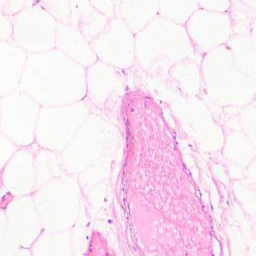

In [323]:
slide.read_region(tuple(coords[3].astype(np.int32)),3,(256,256))

In [366]:
mask=np.zeros((256,256),dtype=np.uint8)
cv2.fillPoly(mask,intersects,color=255)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [367]:
mask.sum()

2627010

In [368]:
import matplotlib.pyplot as plt

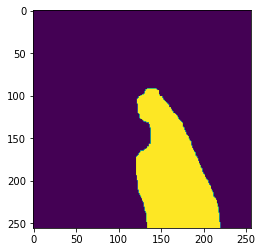

In [369]:
plt.imshow(mask)

In [347]:
intersects[0].dtype

dtype('float64')

In [329]:
intersects[0].shape

(243, 2)

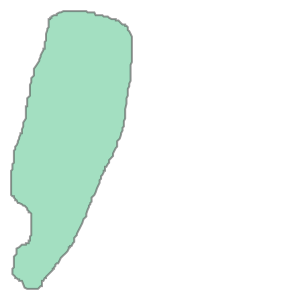

In [286]:
 image_anno_data['polygon'].iloc[0]`

In [288]:
np.array(crop.exterior.coords)

array([[54270., 72995.],
       [56318., 72995.],
       [56318., 70947.],
       [54270., 70947.],
       [54270., 72995.]])

In [271]:
anno_df['image_name']==image_name

0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
9    True
Name: image_name, dtype: bool

In [267]:
image_anno_data['class_name']

0         Region*
1        Positive
2    Immune cells
3        Necrosis
4         Ignore*
5           Tumor
6        Necrosis
7        Necrosis
8        Positive
9           urban
Name: class_name, dtype: object

In [198]:
row=anno_df.iloc[3]

In [204]:
np.random.choice(range(len(row['coordinates'])),1)

array([429])

In [263]:
anno_df.columns

Index(['type', 'geometry', 'properties', 'image_name', 'image_path',
       'WSI_size', 'levels', 'downsample_levels', 'coordinates', 'polygon',
       'area', 'circumference', 'class_name', 'colour_RGB'],
      dtype='object')